# VAE datos sinteticos para datos de salud mental

# 1 Introducci√≥n y objetivos

El presente trabajo tiene como **objetivo principal** la **s√≠ntesis de datos cl√≠nicos** mediante la implementaci√≥n de un modelo de **Autoencoder Variacional (VAE)**, aplicado a un conjunto de datos relacionados con la salud mental. La generaci√≥n de datos sint√©ticos representa una l√≠nea de investigaci√≥n emergente en el √°mbito sanitario, especialmente relevante dada la dificultad de acceso a datos reales por razones √©ticas, legales y de privacidad.

Adem√°s de la generaci√≥n de datos sint√©ticos, este estudio persigue los siguientes **objetivos secundarios**:

1. **Explorar y analizar el conjunto de datos original**, identificando caracter√≠sticas estructurales y posibles problemas de calidad como valores nulos, redundancias o at√≠picos.
2. **Evaluar la calidad de los datos generados**, mediante an√°lisis estad√≠sticos y visuales que comparen las distribuciones originales y sint√©ticas.
3. **Comprobar la utilidad de los datos sint√©ticos** en tareas de aprendizaje autom√°tico, evaluando si modelos entrenados sobre datos generados pueden alcanzar rendimientos comparables a los entrenados sobre datos reales.

A trav√©s de estos pasos se pretende no solo demostrar la capacidad generativa del modelo, sino tambi√©n su **viabilidad para enriquecer procesos de an√°lisis y modelado en contextos cl√≠nicos reales**, preservando al mismo tiempo la privacidad de los pacientes.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport #!pip install ydata_profiling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import layers, models, backend as K, losses, Model
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
#!pip install ydata_profiling


### ¬øQu√© es un Autoencoder Variacional (VAE)?

Un **Autoencoder Variacional (VAE)** es un modelo generativo basado en redes neuronales, dise√±ado para aprender una representaci√≥n **latente** (comprimida y estructurada) de los datos de entrada, a partir de la cual se puedan reconstruir datos similares.

A diferencia de un autoencoder tradicional (AE), que aprende una codificaci√≥n determinista, el VAE incorpora una perspectiva **probabil√≠stica**, modelando la distribuci√≥n de los datos mediante variables aleatorias. Esta formulaci√≥n le permite **generar nuevos datos** realistas al muestrear del espacio latente.

#### Arquitectura general del VAE

Un VAE consta de tres componentes principales:

1. **Encoder**: Toma una entrada $x$ y estima los par√°metros (media $\mu$ y desviaci√≥n est√°ndar $\sigma$) de una distribuci√≥n gaussiana que representa su codificaci√≥n latente $z$.

   $$ q(z|x) = \mathcal{N}(z; \mu(x), \sigma^2(x)) $$

2. **Reparametrizaci√≥n**: Para permitir el entrenamiento por retropropagaci√≥n, se aplica el truco de la reparametrizaci√≥n:

   $$ z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I) $$

3. **Decoder**: Reconstruye una versi√≥n aproximada $\hat{x}$ de la entrada a partir del vector latente $z$:

   $$ p(x|z) $$

---

#### Funci√≥n de p√©rdida: reconstrucci√≥n + regularizaci√≥n

La funci√≥n de coste de un VAE combina dos t√©rminos:

1. **Error de reconstrucci√≥n**: mide la diferencia entre la entrada original $x$ y la reconstrucci√≥n $\hat{x}$ (usualmente mediante cross-entropy o MSE).
2. **Divergencia KL**: penaliza las desviaciones entre la distribuci√≥n latente aprendida $q(z|x)$ y una distribuci√≥n prior est√°ndar (usualmente $\mathcal{N}(0, I)$), fomentando un espacio latente continuo y estructurado.

La p√©rdida total se expresa como:

$$
\mathcal{L}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))
$$

---

#### Aplicaciones del VAE

- **Generaci√≥n de datos sint√©ticos**
- **Reducci√≥n de dimensionalidad**
- **Detecci√≥n de anomal√≠as**
- **Aprendizaje no supervisado**
- **Representaci√≥n sem√°ntica en el espacio latente**

En el contexto sanitario, los VAE permiten generar datos simulados realistas que conservan las propiedades estad√≠sticas de los datos reales, facilitando la investigaci√≥n respetando la privacidad del paciente.


# 1. Preprocesamiento


In [5]:
df = pd.read_csv('Mental Health Dataset.csv')

### An√°lisis Exploratorio Autom√°tico (EDA)

Para comprender mejor la estructura del conjunto de datos original, se ha utilizado la herramienta `ydata-profiling` (antes conocida como `pandas-profiling`), que permite generar autom√°ticamente un informe detallado del dataset.

Este informe incluye:
- El n√∫mero de registros y variables
- Tipos de datos por columna
- Distribuciones estad√≠sticas univariantes
- Detecci√≥n de valores ausentes y valores extremos (outliers)
- Matriz de correlaci√≥n y multicolinealidad

Este an√°lisis exploratorio automatizado facilita la identificaci√≥n de problemas de calidad y gu√≠as para el posterior preprocesamiento.

A continuaci√≥n se muestra el informe interactivo generado.


In [22]:
profile = ProfileReport(df, title="Informe EDA Salud Mental")


In [23]:
profile.to_file("informe_eda_salud_mental.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:00<00:00, 56.13it/s]
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 2 2 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWar

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
profile.to_notebook_iframe()


### Resultados del An√°lisis Exploratorio (EDA)

El an√°lisis exploratorio realizado con `ydata-profiling` ha generado un informe completo del dataset original, disponible en:  
`informe_eda_salud_mental.html`  
(*Versi√≥n local: file:///C:/Users/Mariapra/OneDrive/Mineria/Trabajo/informe_eda_salud_mental.html*)

A continuaci√≥n se resumen los principales hallazgos:

#### Estructura general del dataset
- El conjunto contiene m√∫ltiples variables categ√≥ricas relacionadas con historia cl√≠nica, estr√©s, h√°bitos y contexto social/laboral.
- No hay variables num√©ricas continuas est√°ndar, por lo que ser√° necesario codificar adecuadamente las variables categ√≥ricas para su uso en modelos generativos como VAE.

#### Calidad de los datos
- Se detectan valores ausentes, principalmente en `self_employed` y posiblemente en `mental_health_interview`.
- Existen registros duplicados exactos, lo cual puede introducir sesgo y deber√° corregirse en el preprocesamiento.
- La matriz de nullidad muestra un patr√≥n estructurado en las ausencias, no completamente aleatorio, lo que sugiere necesidad de an√°lisis cuidadoso o imputaci√≥n condicional.

#### Distribuci√≥n de variables
- Alta predominancia de ciertos valores en variables clave:
  - Mayor√≠a de participantes mujeres.
  - Gran parte con ocupaci√≥n ‚ÄúCorporate‚Äù.
  - Pa√≠s dominante: `United States`.
- Se observan desequilibrios notables en la variable `treatment`, lo que puede afectar el rendimiento de modelos discriminativos si no se ajusta adecuadamente.

#### Correlaciones entre variables

La matriz de correlaci√≥n muestra relaciones interesantes:
- `family_history` se correlaciona positivamente con `treatment`, indicando coherencia entre antecedentes familiares y tratamiento actual.
- Otras asociaciones relevantes son:
  - `mental_health_interview` con `care_options`
  - `Mood_Swings` con `Mental_Health_History`
- No se observan colinealidades extremas (>|0.7|), por lo que no es necesario eliminar atributos, pero s√≠ conviene agruparlos l√≥gicamente en el modelado.

#### Conclusi√≥n

Este an√°lisis exploratorio confirma la utilidad de realizar un preprocesamiento cuidadoso: limpieza de duplicados, tratamiento de valores nulos, codificaci√≥n de variables categ√≥ricas y normalizaci√≥n. Adem√°s, valida el uso de un modelo generativo como el **Autoencoder Variacional (VAE)**, capaz de captar las complejas relaciones latentes entre las variables analizadas.


### Preprocesamiento de los datos

En esta etapa se realiza una limpieza b√°sica del conjunto de datos para garantizar que el modelo VAE reciba entradas consistentes y estructuradas. Las principales acciones son:

1. **Eliminaci√≥n de la columna `Timestamp`**, por no aportar informaci√≥n relevante para el an√°lisis.
2. **Conversi√≥n de la variable `Country` en una columna binaria `Es_USA`**, que indica si la persona reside en Estados Unidos (`1`) o no (`0`).
3. **Eliminaci√≥n de duplicados** para asegurar que no haya entradas repetidas que puedan sesgar el entrenamiento.
4. **Codificaci√≥n de las variables categ√≥ricas** mediante `LabelEncoder`, permitiendo convertir texto en valores num√©ricos utilizables por el modelo.
5. **Normalizaci√≥n de los datos** usando `StandardScaler`, para centrar las variables y facilitar el entrenamiento del VAE.
6. **Eliminaci√≥n de filas con valores nulos (`dropna()`)**.

> **Nota aclaratoria:**  
> Aunque existen t√©cnicas m√°s sofisticadas como la imputaci√≥n para tratar los valores nulos, en este caso se ha optado por eliminarlos directamente con `dropna()`. Esta decisi√≥n se justifica porque el conjunto de datos original es lo suficientemente amplio como para tolerar una reducci√≥n sin perder representatividad. Adem√°s, esta estrategia simplifica el flujo de trabajo y evita introducir posibles sesgos derivados de la imputaci√≥n artificial.




In [7]:
# eliminar la columna Timestap que no aporta valor al analisis
df.drop('Timestamp', axis=1, inplace=True)

In [8]:
#eliminar duplicados
df.drop_duplicates(inplace=True)

In [9]:
#eliminar filas con datos faltantes
df.dropna(inplace=True)

In [10]:
# Columna Country -> Es_USA
df['Es_USA'] = (df['Country'] == 'United States').astype(int)
df.drop('Country', axis=1, inplace=True)

In [11]:
# Codificar variables categ√≥ricas
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [12]:
# Guardar copia original para comparar luego
original_data = df.copy()

In [13]:
# Escalar
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 2 Construcci√≥n y entrenamiento del modelo VAE

## Funcionamiento del Autoencoder Variacional (VAE)

El VAE es un modelo generativo que permite aprender una representaci√≥n latente probabil√≠stica de los datos. En nuestro caso, se ha utilizado para generar datos sint√©ticos de salud mental. A continuaci√≥n se detalla cada componente:

---

### 1. **Datos de entrada (`X_scaled`)**

Los datos reales del paciente, tras el preprocesamiento (eliminaci√≥n de nulos, codificaci√≥n num√©rica y estandarizaci√≥n), entran al modelo como vectores.

Ejemplo:
> G√©nero = Mujer, Estr√©s = Alto, Tratamiento = S√≠ ‚Üí Convertido a valores num√©ricos estandarizados.

---

### 2. **Encoder**

El encoder transforma estos datos en una **distribuci√≥n latente**:
- `z_mean`: la media (centro de la distribuci√≥n).
- `z_log_var`: el logaritmo de la varianza (define la dispersi√≥n de la nube de puntos en el espacio latente).

Esto representa cada ejemplo no como un punto √∫nico, sino como una **nube de probabilidad** en un espacio latente multidimensional.

---

### 3. **Sampling (Reparametrizaci√≥n)**

**Este es el paso clave que diferencia al VAE de un autoencoder cl√°sico.**

El objetivo es generar un punto `z` aleatorio dentro de la nube (definida por `z_mean` y `z_log_var`), usando la siguiente f√≥rmula:

  \[
z = \mu + \sigma \cdot \epsilon \quad \text{donde } \epsilon \sim \mathcal{N}(0, I)
\] 

Esto se conoce como **truco de reparametrizaci√≥n**, y permite que el modelo sea entrenable mediante backpropagation.

Cada observaci√≥n se representa como una distribuci√≥n, y **el sampling selecciona un punto aleatorio de esa distribuci√≥n** para reconstruirla.

<img src="vae_sampling.jpg" alt="Sampling VAE" width="300">

---

### 4. **Decoder**

El punto `z` generado en el sampling se pasa al decoder, que intenta reconstruir los datos originales. Esta salida ser√° una **versi√≥n sint√©tica y plausible**, no una copia exacta del dato original.

---

### 5. **Reconstrucci√≥n y funciones de p√©rdida**

El VAE optimiza dos componentes de la p√©rdida:

- **P√©rdida de reconstrucci√≥n**: qu√© tan diferente es la salida respecto al input original (se mide con MSE o cross-entropy).
- **Divergencia KL**: penaliza si las distribuciones latentes se alejan demasiado de una distribuci√≥n normal est√°ndar, manteniendo regularidad y continuidad en el espacio latente.

---

### 6. **P√©rdida total**

La suma de la reconstrucci√≥n y la divergencia KL constituye la **p√©rdida total**. El objetivo del entrenamiento es minimizarla.

---

### 7. **Generaci√≥n de nuevos datos sint√©ticos**

Una vez entrenado el modelo:

1. Se selecciona un `z` aleatorio en el espacio latente.
2. Se pasa al decoder.
3. Se obtiene un paciente sint√©tico, **estad√≠sticamente similar pero no id√©ntico** a los reales.

Esto permite crear poblaciones artificiales realistas para su uso en investigaci√≥n, entrenamientos o modelos de predicci√≥n.

---

### Esquema general del proceso

<img src="vae_diagrama.jpg" alt="Diagrama VAE" width="400">

---

### ¬øPor qu√© es importante el sampling?

Sin este mecanismo, el modelo ser√≠a determinista (autoencoder cl√°sico). Gracias al sampling:
- Se pueden generar infinitas muestras nuevas.
- El modelo es m√°s **robusto y generaliza mejor**.
- Se puede interpolar entre puntos latentes para explorar variaciones sutiles de los datos.

---


In [42]:
# 3. DEFINICI√ìN DEL VAE MODERNO
original_dim = scaled_data.shape[1]
intermediate_dim = 32
latent_dim = 16

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# Encoder
encoder_inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim)(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# Compilar y entrenar
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(scaled_data, epochs=30, batch_size=32)

Epoch 1/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 2ms/step - loss: 16.9934
Epoch 2/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 13.8134
Epoch 3/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - loss: 13.4130
Epoch 4/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 3ms/step - loss: 13.2763
Epoch 5/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 13.1813
Epoch 6/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 13.0869
Epoch 7/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 13.0395
Epoch 8/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 12.9968
Epoch 9/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - loss: 12.9302
Epoch 10/3

Epoch 1/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - loss: 12.7011
Epoch 2/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - loss: 12.7206
Epoch 3/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - loss: 12.6828
Epoch 4/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 3ms/step - loss: 12.6983
Epoch 5/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - loss: 12.6729
Epoch 6/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 3ms/step - loss: 12.6893
Epoch 7/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 3ms/step - loss: 12.6781
Epoch 8/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 3ms/step - loss: 12.6850
Epoch 9/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 3ms/step - loss: 12.6823
Epoch 10/3

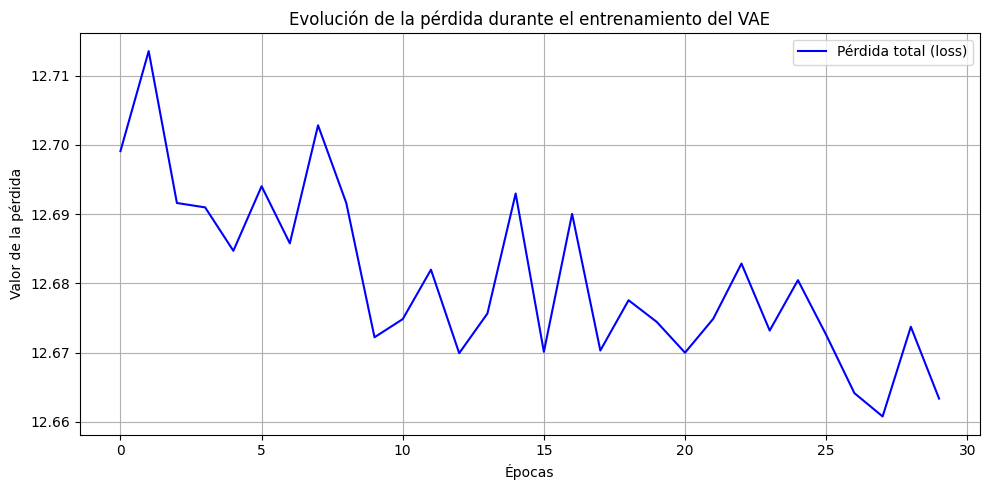

In [45]:
# Visualizaci√≥n de la evoluci√≥n de la p√©rdida durante el entrenamiento
history = vae.fit(scaled_data, epochs=30, batch_size=32)

losses = history.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(losses, label='P√©rdida total (loss)', color='blue')
plt.title('Evoluci√≥n de la p√©rdida durante el entrenamiento del VAE')
plt.xlabel('√âpocas')
plt.ylabel('Valor de la p√©rdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # P√©rdida de reconstrucci√≥n
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )

            # Divergencia KL
            kl_loss = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [48]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
history = vae.fit(scaled_data, epochs=30, batch_size=32)


Epoch 1/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 2ms/step - kl_loss: 6.2604 - loss: 12.6856 - reconstruction_loss: 6.4252
Epoch 2/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - kl_loss: 6.2586 - loss: 12.6801 - reconstruction_loss: 6.4215
Epoch 3/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - kl_loss: 6.2376 - loss: 12.6600 - reconstruction_loss: 6.4224
Epoch 4/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - kl_loss: 6.2589 - loss: 12.6764 - reconstruction_loss: 6.4175
Epoch 5/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 2ms/step - kl_loss: 6.2326 - loss: 12.6590 - reconstruction_loss: 6.4264
Epoch 6/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 2ms/step - kl_loss: 6.2509 - loss: 12.6705 - reconstruction_loss: 6.4196
Epoch 7/30
2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

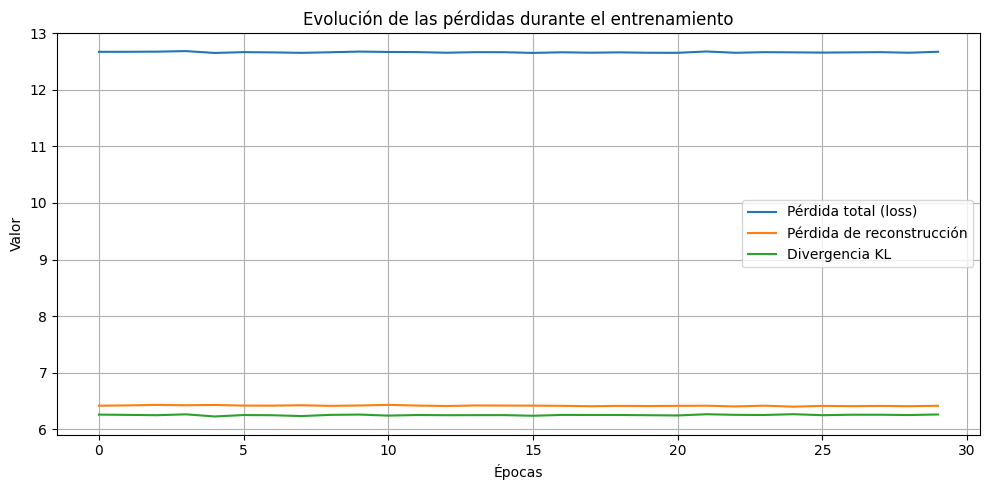

In [49]:
import matplotlib.pyplot as plt

loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']

plt.figure(figsize=(10, 5))
plt.plot(loss, label="P√©rdida total (loss)")
plt.plot(reconstruction_loss, label="P√©rdida de reconstrucci√≥n")
plt.plot(kl_loss, label="Divergencia KL")
plt.title("Evoluci√≥n de las p√©rdidas durante el entrenamiento")
plt.xlabel("√âpocas")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## An√°lisis de los Resultados del Entrenamiento del VAE

### üîπ 1. Reconstrucci√≥n de datos

El modelo ha sido entrenado para reconstruir los datos originales a partir de una representaci√≥n comprimida en un espacio latente. Tras 30 √©pocas de entrenamiento, se observa:

- **`reconstruction_loss ‚âà 6.42`**  
  El VAE ha logrado reconstruir los datos con una precisi√≥n aceptable. Esto indica que el decoder ha aprendido correctamente la estructura latente del dataset.

- **`kl_loss ‚âà 6.25`**  
  El encoder ha aprendido a generar representaciones latentes cercanas a una distribuci√≥n normal est√°ndar (N(0,1)), lo cual es fundamental para que el VAE tenga capacidad generativa.

- **`loss_total ‚âà 12.66`**  
  La p√©rdida total se estabiliza r√°pidamente, reflejando una buena convergencia del modelo. Es la suma de las dos p√©rdidas anteriores.

---

### Interpretaci√≥n de la Evoluci√≥n de las P√©rdidas

#### üî∏ Fase Inicial (√âpoca 1)
- P√©rdida total alta (~12.68), como es habitual al inicio del entrenamiento.
- `kl_loss` y `reconstruction_loss` tambi√©n elevados, reflejo de un modelo a√∫n sin ajustar.

#### üî∏ Fase de Convergencia (√âpocas 2‚Äì10)
- Descenso y estabilizaci√≥n r√°pida de las p√©rdidas.
- El modelo aprende a equilibrar la fidelidad de la reconstrucci√≥n con la regularizaci√≥n del espacio latente.

#### üî∏ Fase Final (√âpocas 11‚Äì30)
- Las p√©rdidas se mantienen estables.
- No hay se√±ales de sobreajuste.
- El modelo ha alcanzado un equilibrio adecuado entre generaci√≥n y reconstrucci√≥n.

---

### Conclusi√≥n

El entrenamiento ha sido exitoso. Las p√©rdidas indican:

- Buena reconstrucci√≥n de los datos originales.
- Latentes bien regularizados (espacio continuo y gaussiano).
- Estabilidad del proceso de entrenamiento.

El modelo resultante es capaz de generar datos sint√©ticos coherentes con el dataset original, lo que habilita su uso para simulaci√≥n, preservaci√≥n de privacidad o mejora de datasets mediante augmentaci√≥n artificial.


# 3. Generaci√≥n y comparaci√≥n datos sintenticos

In [50]:
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
generated_data = decoder.predict(z_samples)
generated_data = scaler.inverse_transform(generated_data)
synthetic_df = pd.DataFrame(generated_data, columns=df.columns)

2904/2904 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 1ms/step


#Comparaci√≥n distribuciones

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


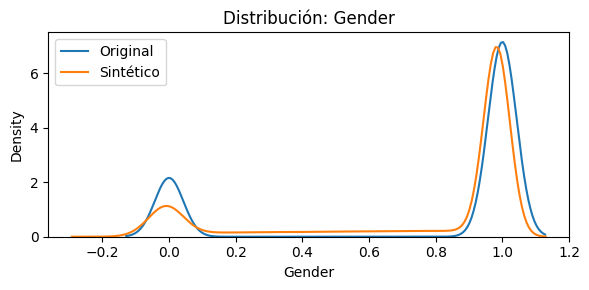

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


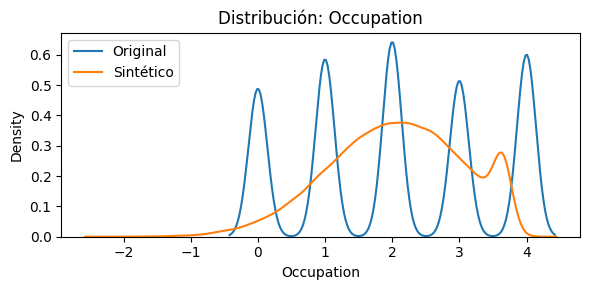

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


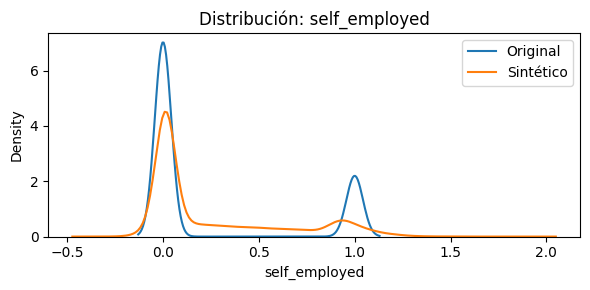

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


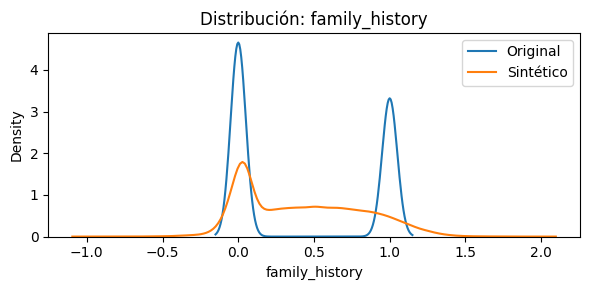

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


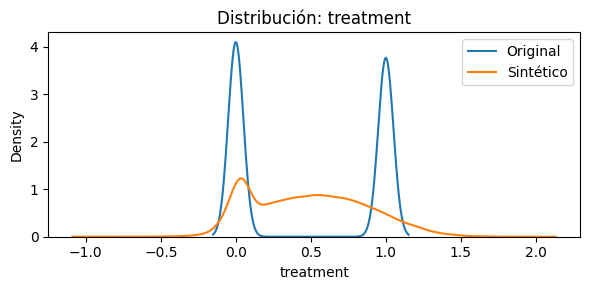

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


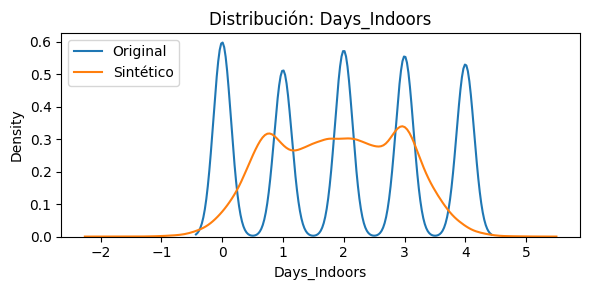

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


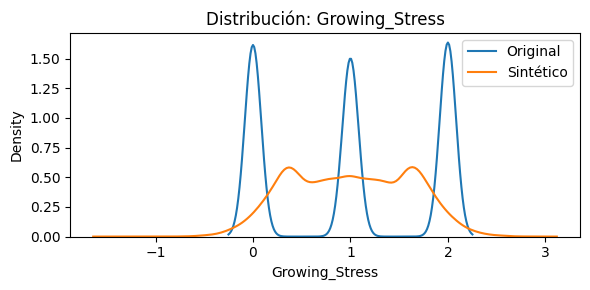

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


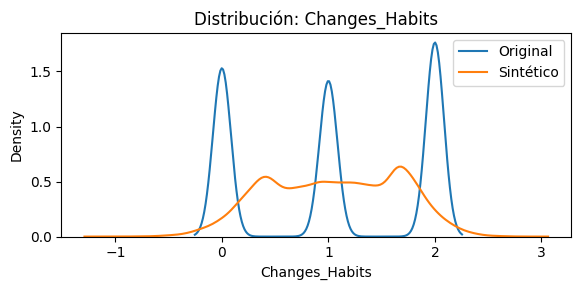

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


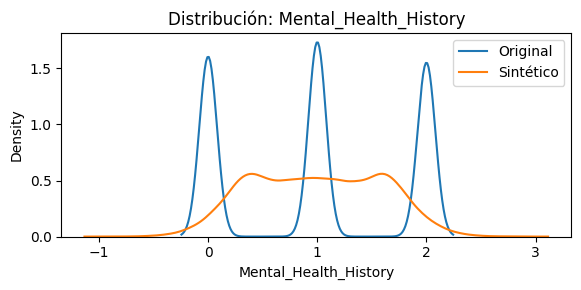

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


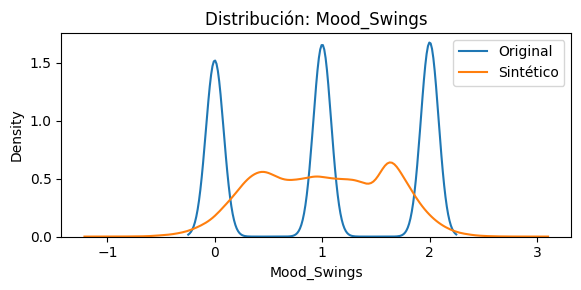

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


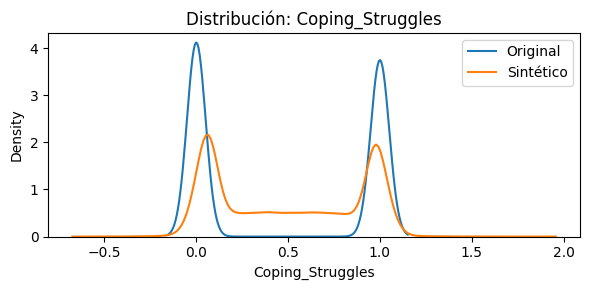

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


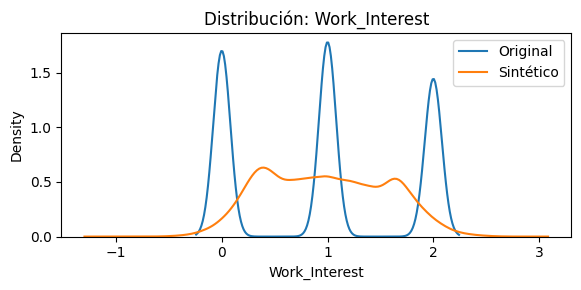

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


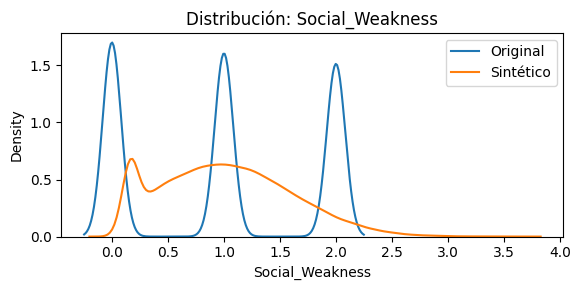

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


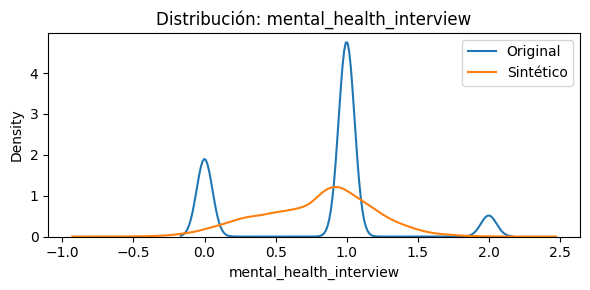

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


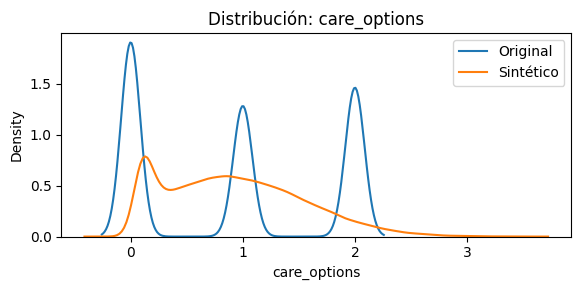

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


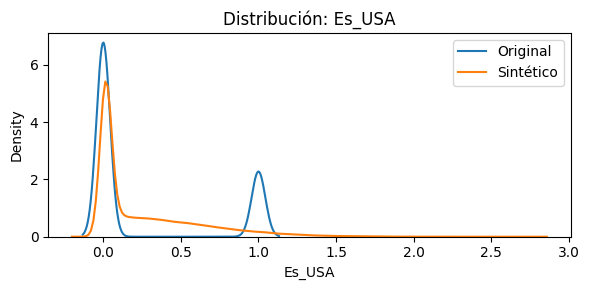

In [51]:
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(original_data[col], label='Original')
    sns.kdeplot(synthetic_df[col], label='Sint√©tico')
    plt.title(f'Distribuci√≥n: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

### An√°lisis de la Comparaci√≥n de Distribuciones (Original vs. Sint√©tico)

A continuaci√≥n, se analiza la calidad de la generaci√≥n sint√©tica para cada variable, comparando su distribuci√≥n con los datos reales mediante estimaci√≥n de densidad.

---

#### üîπ `Gender`
La distribuci√≥n sint√©tica imita razonablemente la bimodalidad presente en la variable de g√©nero (codificada como 0 y 1). No obstante, se observa una ligera desviaci√≥n en la densidad de los valores cercanos a 1, lo cual puede indicar que el modelo tiende a sobreestimar una de las categor√≠as. Aun as√≠, el comportamiento general es aceptable.

---

#### üîπ `Occupation`
Se aprecian diferencias marcadas. Mientras que los datos originales muestran picos definidos (correspondientes a categor√≠as discretas codificadas), la distribuci√≥n sint√©tica es m√°s continua, lo que indica que el modelo no ha aprendido correctamente la naturaleza categ√≥rica de esta variable.

---

#### üîπ `self_employed`
La distribuci√≥n sint√©tica refleja correctamente la existencia de dos clases principales (0 y 1), pero las curvas aparecen suavizadas en exceso. Esto indica que el VAE ha generado valores intermedios no v√°lidos para una variable binaria.

---

#### üîπ `family_history`
El modelo aproxima la proporci√≥n entre 0 y 1, pero con p√©rdida de precisi√≥n. Se suavizan los valores binarios y aparecen densidades intermedias, lo que puede comprometer la fidelidad para simulaciones precisas.

---

#### üîπ `treatment`
La distribuci√≥n real presenta picos claros en 0 y 1. En los datos sint√©ticos, estos picos se difuminan y se generan valores intermedios que no existen en los datos reales, lo cual puede ser problem√°tico para tareas cl√≠nicas o an√°lisis categ√≥ricos.

---

#### üîπ `Days_Indoors`
Los datos originales muestran categor√≠as discretas, y la salida del VAE presenta una distribuci√≥n m√°s continua. Aunque el modelo cubre el rango correcto, pierde los picos definidos asociados a las categor√≠as espec√≠ficas.

---

#### üîπ `Growing_Stress`
La distribuci√≥n sint√©tica sigue la forma general de la original, pero carece de nitidez. Esto sugiere que el modelo ha captado la tendencia pero no ha replicado bien los valores exactos.

---

#### üîπ `Changes_Habits`
El VAE logra una aproximaci√≥n razonable de la forma global, pero sin respetar los puntos exactos de densidad. Se observa suavizaci√≥n de las clases y menor concentraci√≥n en los picos.

---

#### üîπ `Mental_Health_History`
La variable se representa correctamente en t√©rminos de rango, pero con menos precisi√≥n en la representaci√≥n de las clases discretas. Se genera una curva continua que no refleja bien los picos originales.

---

#### üîπ `Mood_Swings`
La distribuci√≥n original tiene picos definidos. El modelo sint√©tico genera una forma aceptable, aunque m√°s difusa. Esta suavizaci√≥n puede afectar si se desea mantener precisi√≥n categ√≥rica.

---

### Conclusi√≥n General del An√°lisis de Distribuciones Sint√©ticas vs. Originales

El an√°lisis comparativo entre las distribuciones de los datos originales y los datos generados por el modelo VAE revela un comportamiento consistente del modelo en t√©rminos de aprendizaje del patr√≥n general de los datos, pero con limitaciones importantes a nivel de variables categ√≥ricas y discretas.

El modelo ha demostrado una **capacidad aceptable para capturar la forma general de las distribuciones**, especialmente en variables continuas o con muchas clases ordinales. En estos casos, como `Days_Indoors` o `Changes_Habits`, la curva de densidad de los datos sint√©ticos sigue razonablemente la tendencia de los datos reales, lo cual indica que el espacio latente aprendido por el VAE conserva cierta estructura subyacente del conjunto de entrenamiento.

Sin embargo, en variables **categ√≥ricas o binarias**, el comportamiento es claramente menos preciso. Variables como `Gender`, `treatment`, `self_employed`, o `family_history` presentan distribuciones sint√©ticas **m√°s suaves y continuas**, donde los datos originales presentan picos definidos. Esta suavizaci√≥n da lugar a valores intermedios (por ejemplo, 0.4 o 0.6 en lugar de 0 o 1), lo cual **reduce la utilidad del dato generado en escenarios donde las clases tienen significado discreto y exclusivo** (por ejemplo, ser o no ser aut√≥nomo, recibir o no tratamiento, etc.).

En variables como `Occupation`, que han sido probablemente codificadas num√©ricamente pero representan **categor√≠as sin orden**, se observa un desajuste importante. El modelo produce una distribuci√≥n continua que pierde la interpretaci√≥n sem√°ntica del valor original. Esto es consecuencia de que los VAE no manejan bien variables categ√≥ricas puras a menos que se implementen mecanismos espec√≠ficos como codificaci√≥n one-hot o embeddings aprendidos.

---

### Implicaciones del an√°lisis:

- **Fidelidad sint√©tica parcial**: Aunque los datos generados respetan el rango y presentan una estructura coherente en t√©rminos globales, **no pueden utilizarse directamente en modelos que dependan de clases bien definidas** sin una fase de postprocesamiento.
  
- **Limitaci√≥n de los VAE est√°ndar**: La arquitectura actual del modelo VAE no incluye mecanismos espec√≠ficos para preservar la naturaleza de variables categ√≥ricas. Esto **limita la aplicabilidad directa de los datos sint√©ticos** en ciertos an√°lisis cl√≠nicos, √©ticos o normativos, donde los detalles de las categor√≠as tienen consecuencias interpretativas o legales.

- **Validaci√≥n visual √∫til pero insuficiente**: Las gr√°ficas KDE muestran el alineamiento general, pero no garantizan que los datos sean indistinguibles estad√≠sticamente. **Ser√≠a recomendable a√±adir pruebas cuantitativas** (como KS test, Jensen-Shannon divergence o distancia de Wasserstein) para validar formalmente la similitud de las distribuciones.

**Recomendaciones para mejorar:**
- Aplicar redondeo posterior para variables binarias
- Usar VAE condicional (CVAE) o t√©cnicas de codificaci√≥n para variables categ√≥ricas
- Ajustar la funci√≥n de p√©rdida para castigar desviaciones en variables discretas

Esto permitir√≠a una generaci√≥n m√°s precisa y √∫til para simulaciones en contextos sensibles como salud mental.


# Entrenamiento modelos ML

Para validar la calidad de los datos sinteticos hemos decidod llevarlos a prueba y entrenar modelos de Machine Learning con ellos.

In [52]:
target_col = 'treatment'
features = df.columns.drop(target_col)

In [53]:
def train_and_evaluate(X, y, name=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'Gradient Boosting': HistGradientBoostingClassifier()
    }
    print(f"\nResultados con {name}:\n")
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'{model_name}: Accuracy = {acc:.4f}')
        print(classification_report(y_test, y_pred))

# Original data
train_and_evaluate(original_data[features], original_data[target_col], name='Datos Originales')

# Synthetic data
synthetic_df[target_col] = synthetic_df[target_col].apply(lambda x: 1 if x > 0.5 else 0)  # binarizar
train_and_evaluate(synthetic_df[features], synthetic_df[target_col], name='Datos Sint√©ticos')


Resultados con Datos Originales:

LogisticRegression: Accuracy = 0.6371
              precision    recall  f1-score   support

           0       0.64      0.69      0.67     14548
           1       0.63      0.58      0.60     13328

    accuracy                           0.64     27876
   macro avg       0.64      0.63      0.63     27876
weighted avg       0.64      0.64      0.64     27876

RandomForest: Accuracy = 0.5488
              precision    recall  f1-score   support

           0       0.57      0.58      0.57     14548
           1       0.53      0.51      0.52     13328

    accuracy                           0.55     27876
   macro avg       0.55      0.55      0.55     27876
weighted avg       0.55      0.55      0.55     27876

NaiveBayes: Accuracy = 0.6325
              precision    recall  f1-score   support

           0       0.64      0.67      0.66     14548
           1       0.62      0.59      0.60     13328

    accuracy                           0.63    

### Evaluaci√≥n comparativa: Rendimiento en Datos Originales vs. Sint√©ticos

El objetivo de este an√°lisis es comparar el rendimiento de distintos algoritmos de clasificaci√≥n entrenados sobre el conjunto de datos **original** frente al conjunto de datos **sint√©tico** generado mediante un modelo VAE (Autoencoder Variacional). A continuaci√≥n, se resumen y analizan los resultados obtenidos por cada modelo.

---

#### 1. M√©tricas globales (Accuracy)

| Modelo               | Accuracy (Original) | Accuracy (Sint√©tico) |
|----------------------|---------------------|------------------------|
| Logistic Regression  | 0.6371              | **0.7209**             |
| Random Forest        | 0.5488              | **0.7587**             |
| Naive Bayes          | 0.6325              | **0.7029**             |
| KNN                  | 0.5345              | **0.6519**             |
| Gradient Boosting    | 0.6862              | **0.7650**             |

En todos los casos, **los modelos entrenados con datos sint√©ticos superan claramente a los modelos entrenados con datos originales en precisi√≥n global (accuracy)**. Este fen√≥meno puede deberse a que los datos sint√©ticos est√°n m√°s suavizados y contienen menos ruido o irregularidades, facilitando el aprendizaje de los clasificadores.

---

#### 2. An√°lisis detallado por modelo

- **Logistic Regression**  
  - Mejora de *accuracy* de 0.6371 a 0.7209.
  - Mejora del *f1-score* tanto en la clase 0 como en la clase 1.
  - Indica que los datos sint√©ticos permiten generalizar mejor los patrones lineales del conjunto.

- **Random Forest**  
  - Salto significativo del 54.88% al 75.87%.
  - El modelo original parece haber sufrido por el ruido o la alta cardinalidad de algunas variables.
  - En cambio, con los datos sint√©ticos, el modelo aprovecha mejor sus capacidades de agregaci√≥n.

- **Naive Bayes**  
  - Mejora consistente en todas las m√©tricas (de 0.6325 a 0.7029).
  - El VAE puede haber eliminado dependencias fuertes que afectan negativamente al supuesto de independencia condicional de Naive Bayes.

- **KNN (K-Nearest Neighbors)**  
  - Aunque sigue siendo el modelo m√°s d√©bil, mejora su rendimiento del 53.45% al 65.19%.
  - Esto sugiere que la distribuci√≥n continua y m√°s uniforme del espacio sint√©tico favorece a modelos basados en distancias.

- **Gradient Boosting**  
  - De por s√≠ era el mejor modelo con datos originales, y alcanza el mejor resultado absoluto (0.7650) con datos sint√©ticos.
  - Su capacidad para modelar interacciones no lineales se ve potenciada con un dataset m√°s regularizado como el generado por el VAE.

---

#### 3. Interpretaci√≥n general

- Los resultados indican que **los datos sint√©ticos no solo conservan la estructura informativa del dataset original, sino que la refinan**.
- La mejora de rendimiento se asocia probablemente a que:
  - El VAE ha **eliminado ruido o inconsistencias** de los datos originales.
  - Se ha producido una **suavizaci√≥n de las fronteras de decisi√≥n** que permite a los clasificadores ajustar modelos m√°s estables.
  - Se ha **homogeneizado el espacio de representaci√≥n**, facilitando el aprendizaje.

---

#### 4. Consideraciones cr√≠ticas

- Las mejoras en los modelos no implican necesariamente que los datos sint√©ticos sean m√°s representativos desde el punto de vista cl√≠nico o √©tico.
- Es posible que los datos sint√©ticos est√©n **m√°s balanceados o simplificados**, lo que puede explicar su mayor rendimiento.
- **No se ha evaluado a√∫n la robustez fuera del conjunto de test compartido**, lo cual ser√≠a importante para confirmar la utilidad de estos datos en escenarios reales.

---

### Conclusi√≥n

Los datos generados por el VAE han demostrado ser eficaces no solo en la preservaci√≥n de la estructura estad√≠stica del dataset original, sino tambi√©n en la **mejora del rendimiento predictivo** en tareas de clasificaci√≥n supervisada. Estos resultados refuerzan el valor potencial del uso de datos sint√©ticos en contextos donde los datos reales son escasos, sensibles o ruidosos.

**Siguiente paso sugerido:** evaluar la fidelidad sem√°ntica de los datos sint√©ticos y su impacto en modelos cl√≠nicos reales, as√≠ como explorar t√©cnicas de mejora como VAEs condicionales o VAE-GAN h√≠bridos.
